# Take sample of tweets based on classification scores for Covid-19 myths

@authors: Jaren Haber, Alexander Chen, Kornraphop Kawintiranon<br>
@affiliation: Massive Data Institute, McCourt School of Public Policy, Georgetown University<br>
@date: November 2, 2020

'''
Uses classifiers trained on labeled tweets (about a myth vs. not) to select a sample of 180 tweets for labeling on MTurk (280 for weather myth). Data source is tweets with hashtags related to Covid-19. For the first batch using this script, 90% of these selected tweets are predicted to be of the minority class for that myth: e.g., yes on weather, yes on disinfectants, or yes on home remedies. The remaining 10% are from majority class, which are easier to predict in our skewed first batch of data. Future batches may use a more balanced sampling procedure. 
'''

## Initialize

In [1]:
# Install anything not already in server
#!pip install gcsfs
# !pip install nltk
# !pip install emoji
#!pip install --upgrade scikit-learn # need to update sklearn for Jaren's VM

import nltk
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /home/ac1975/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ac1975/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
######################################################
# Import libraries
######################################################

import pandas as pd
import numpy as np
import re, csv, os
from datetime import date
from random import sample
from collections import Counter
import gcsfs # for quick loading of data from gcloud
from tqdm import tqdm
tqdm.pandas()
import time

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

stemmer = WordNetLemmatizer()

from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt

import joblib
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import emoji
import math

/home/ac1975/anaconda3/lib/python3.7/site-packages/tqdm/std.py:703: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [3]:
######################################################
# Define filepaths
######################################################

bucket_fp = 'gs://project_coronavirus/raw/hashtag/'

dis_mod_fp = '../models/tweet_classifier_disinfectants.joblib'
rem_mod_fp = '../models/tweet_classifier_home_remedies.joblib'
wth_mod_fp = '../models/tweet_classifier_weather.joblib'

dis_vec_fp = '../models/vectorizer_disinfectants.joblib'
rem_vec_fp = '../models/vectorizer_home_remedies.joblib'
wth_vec_fp = '../models/vectorizer_weather.joblib'

n_sample = 180
thisday = date.today().strftime("%d%m%y")

dis_sam_fp = f'../data/myth_disinfectants_sample_{str(n_sample)}_{str(thisday)}.csv'
rem_sam_fp = f'../data/myth_home_remedies_sample_{str(n_sample)}_{str(thisday)}.csv'
wth_sam_fp = f'../data/myth_weather_sample_{str(n_sample)}_{str(thisday)}.csv'

In [4]:
def read_tweets (dirname, 
                 num_rand_files = 0, 
                 start_week_num = -1, 
                 end_week_num = 0, 
                 levels = 1, 
                 nrows = 50, 
                 previous_tweets = [],
                 language = 'en'):
    
    """
    Read latest Twitter data from JSON files. 
    Options: take random number of files from each folder, 
    look only at folders for weeks within specified range, and/or 
    read files in single folder (1 level) or folder of folders (2 levels).
    
    Args:
        dirname: folder in Google Cloud Compute Server where Twitter JSON files live
        num_rand_files: number of random files to draw from each folder. Useful when randomly sampling from files with lots of tweets
        start_week_num: first week in range (to take tweets from), inclusive
        end_week_num: last week in range (to take tweets from), inclusive
        levels: number of folders in hierarchy ('dirname/file1, dirname/file2, etc.' = one level)
        nrows: number of tweets to read from file
        previous_tweets: list of previous samples to remove duplicate tweets
        language: filter to only tweets in this language
    Returns:
        df: DataFrame with loaded in Twitter data
    """
    
    fs = gcsfs.GCSFileSystem(project="MDI-1", token="cloud")
    
    if levels == 2: # two levels (multiple folders)
        files = []
        folders = [folder for folder in fs.ls(dirname) 
                   if folder != dirname 
                   and os.path.join("gs://", folder) != dirname] # don't keep duplicate folders = same as dirname
        
        for folder in folders:
            # only process folders where: start_week_num < week_number < end_week_num
            week_num = int(folder.split('/')[-1][9:]) # get week number: last part of file path, anything after '2020-week'
            if week_num < start_week_num or (end_week_num > 0 and week_num > end_week_num):
                continue # skip if not in week range
            
            # for folders of weeks in desired range, get their files
            listf = fs.ls(os.path.join("gs://", folder)) # get list of files in this folder
            listf = [re.sub(r"#", r"%23", file) for file in listf] # in each file name, replace '#' with '%23' so pandas can read it
            if num_rand_files > 0:
                listf = sample(listf, num_rand_files) # get specified number of random files
            files.extend(listf) # add each file to list
            files = [x for x in files if x.endswith(".json") or x.endswith(".json.gz")]
            
    else: # one level (just one folder)
        files = fs.ls(dirname)
        files = [x for x in files if x.endswith(".json") or x.endswith(".json.gz")]
        if num_rand_files > 0:
            files = sample(listf, num_rand_files) # get specified number of random files
    
    print(f"Reading in tweets from {len(files)} JSON files...")
    
    # Load and merge files as DFs
    dfs = []
    for f in tqdm(files):
        #print("gs://{}".format(f))
        thisdf = pd.read_json("gs://{}".format(f), nrows = nrows, lines=True)
        if 'lang' in thisdf.columns:
            thisdf['language'] = thisdf['lang'] # funnel 'lang' to 'language' column
            thisdf.drop(columns = 'lang', inplace = True) # erase 'lang' column (now a duplicate)
        thisdf = thisdf[(thisdf['language'] == 'null') | (thisdf['language']==language)] # Filter to only tweets in language
        dfs.append(thisdf)
    df = pd.concat(dfs, ignore_index = True)
    df['id'] = df['id'].astype(str)
    
    # Remove duplicate tweets
    for id in previous_tweets:
        df = df[df['id'] != id] 
    
    return df

## Load & inspect data

In [5]:
######################################################
# Load ML models for classifying COVID-19 myths in tweets
######################################################

dis_mod = joblib.load(dis_mod_fp)
rem_mod = joblib.load(rem_mod_fp)
wth_mod = joblib.load(wth_mod_fp)

In [6]:
######################################################
# Load vectorizers to keep vocab consistent with training data
######################################################

dis_vec = joblib.load(dis_vec_fp)
rem_vec = joblib.load(rem_vec_fp)
wth_vec = joblib.load(wth_vec_fp)

In [7]:
######################################################
# Load previous samples for duplicate check
######################################################
previous_fp = ['../data/myth_disinfectants_sample-440.csv',
               '../data/myth_home_remedies_sample-440.csv',
               '../data/myth_weather_sample-440.csv']
previous_dfs = []
for fp in previous_fp:
    previous_dfs.append(pd.read_csv(fp, names=['id']))
previous_ids = pd.concat(previous_dfs, ignore_index = True)
previous_ids

,id
0,full_text_censored
1,#coronavirus #coronarvirusitalia \n!!! Few r...
2,"Clorox Healthcare Bleach Germicidal Wipes, 50 ..."
3,"@USER01 #coronavirus is man made, something we..."
4,@USER01 #JeffBezos knows what's coming.\n#Chin...
...,...
1318,Thanks to the Sarajevo @USER office I still ge...
1319,"Officially, USA has 650+ confirmed #COVID cas..."
1320,@USER What's Logic ???\nWe are (india) hot wea...
1321,How Will Warm Weather Affect The Spread Of COV...


In [8]:
######################################################
# Load and inspect the data
######################################################

df = read_tweets(bucket_fp, 
                 num_rand_files = 1, 
                 start_week_num = 14, 
                 end_week_num = 35, 
                 levels = 2, 
                 nrows = 1000,
                 previous_tweets = previous_ids,
                 language='en')

print('Number of rows (tweets) and cols in DF:', str(df.shape))
print()
print('Columns in tweets DF:\n', str(df.columns))
print()

# See examples of two tweets. 
# Have usernames and URLs already been replaced?
print("Example tweet 1:\n", df['full_text'].iloc[0])
print()
print("Example tweet 2:\n", df['full_text'].iloc[10])
print()

df.head(5)

  0%|          | 0/21 [00:00<?, ?it/s]

Reading in tweets from 21 JSON files...


100%|██████████| 21/21 [02:24<00:00,  6.86s/it]


Number of rows (tweets) and cols in DF: (5407, 62)

Columns in tweets DF:
 Index(['created_at', 'id', 'id_str', 'full_text', 'truncated',
       'display_text_range', 'entities', 'metadata', 'source',
       'in_reply_to_status_id', 'in_reply_to_status_id_str',
       'in_reply_to_user_id', 'in_reply_to_user_id_str',
       'in_reply_to_screen_name', 'user', 'geo', 'coordinates', 'place',
       'contributors', 'retweeted_status', 'is_quote_status', 'retweet_count',
       'favorite_count', 'favorited', 'retweeted', 'possibly_sensitive',
       'extended_entities', 'quoted_status_id', 'quoted_status_id_str',
       'quoted_status', 'language', 'conversation_id', 'date', 'time',
       'timezone', 'user_id', 'username', 'name', 'tweet', 'mentions', 'urls',
       'photos', 'replies_count', 'retweets_count', 'likes_count', 'hashtags',
       'cashtags', 'link', 'retweet', 'quote_url', 'video', 'thumbnail',
       'near', 'user_rt_id', 'user_rt', 'retweet_id', 'reply_to',
       'retweet_

,created_at,id,id_str,full_text,truncated,display_text_range,entities,metadata,source,in_reply_to_status_id,...,near,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest,withheld_in_countries
0,2020-04-05 03:01:16+00:00,1246633976594345986,1.246634e+18,RT @SareesIndia: Art silk blue saree teamed up...,False,"[0, 140]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-04-05 02:47:51+00:00,1246630603941871616,1.246631e+18,RT @SareesIndia: Banarasi silk orange saree te...,False,"[0, 139]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-04-05 01:57:32+00:00,1246617940708986880,1.246618e+18,RT @SareesIndia: Banarasi silk grey saree team...,False,"[0, 140]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-04-05 01:30:12+00:00,1246611060959907842,1.246611e+18,Banarasi silk orange saree teamed up with a ma...,False,"[0, 261]","{'hashtags': [{'text': 'indianweddingsaree', '...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://www.hootsuite.com"" rel=""nofol...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-04-05 05:15:51+00:00,1246667846316363776,1.246668e+18,I have successfully completed #SARI Treatment ...,False,"[0, 121]","{'hashtags': [{'text': 'SARI', 'indices': [30,...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Preprocess text data

In [9]:
punc_pattern = r"[\p{P}\p{S}](?<![@#\'\/:])"

In [10]:
######################################################
# Tweet Preprocessing
######################################################

def process_tweets(tweet):
    '''
    Preprocesses raw text of a tweet, skipping any retweets. 
    Steps: lower-casing; removing punctuation, newlines, URLs, usernames, and emojis;
    stripping whitespace, replacing hashtags, and finally, lemmatization.
    
    args:
        tweet: raw text of a tweet
    
    returns:
        string: cleaned tweet text
    '''
    
    # Skip retweets and non-strings
    retweet_pattern = r'^RT\s+' # recognize retweets by starting with 'RT'
    if not isinstance(tweet, str) or re.search(retweet_pattern, tweet):
        return ''
    
    # Convert to lowercase
    tweet = tweet.lower()
    
#     # Remove punctuation with regex: match all punctuation (\p{P}) and symbols (\p{S}), 
#     # then check that it is not a wasn't a hashtag or @-symbol using a negative look-behind.
#     # Source: https://github.com/georgetown-mdi/processing-jobs/blob/master/pyspark/shared/text_helpers.py
#     punc_pattern = r"[\\p{P}\\p{S}](?<![@#\'\/:])"
#     tweet = re.sub(punc_pattern, "", tweet)   
    
    # Repair hashtag and remove newline character
    # from text_helpers.tweet_text_cleanup
    tweet = tweet.replace("# ", "#")
    tweet = tweet.replace("\n", " ")
    
    # remove URLs and @mentions
    # Simple regular expression to match URLs starting with `https` or `http`
    # More complex regex an be found here: https://mathiasbynens.be/demo/url-regex
    url_regex = r"https?://\S*"
    # Regex to match mentions
    mention_regex = r"@\S*"
    tweet = re.sub(url_regex, "", tweet)
    tweet = re.sub(mention_regex, "", tweet)
        
    # Remove additional white spaces
    whitespace_pattern = r'\s+'
    tweet = re.sub(whitespace_pattern, ' ', tweet) # strip whitespaces in between words
    tweet = tweet.strip() # strip whitespaces at start & end
    
    # Replace #word with word
    tweet = re.sub(r'#([^\s]+)', r'\1', tweet)
    
    # Remove emojis
    tweet = emoji.get_emoji_regexp().sub(u'', tweet)
    
    # Lemmatization
    tweet = tweet.split()
    tweet = ' '.join([stemmer.lemmatize(word) for word in tweet])
    
    
    return tweet

print("Preprocessing tweets...")
df['text_cleaned'] = df['full_text'].progress_apply(lambda x: process_tweets(x))
df = df[df['text_cleaned']!=''] # Filter to only non-empty text_cleaned tweets
df.reset_index(inplace=True)

  0%|          | 0/5407 [00:00<?, ?it/s]

Preprocessing tweets...


100%|██████████| 5407/5407 [00:03<00:00, 1698.01it/s]


In [11]:
# Take a look at two (probably different) tweets post-preprocessing
print("Example tweet 1 (cleaned):\n", df['text_cleaned'].iloc[0])
print()
print("Example tweet 2 (cleaned):\n", df['text_cleaned'].iloc[10])
print()

Example tweet 1 (cleaned):
 banarasi silk orange saree teamed up with a matching blouse beautified with embroidered, weaving. . . price: us$ 100.10 . . product code: 1639229 . . . indianweddingsaree ethnicwear traditional saree sari womenfashion womendress indiandress indianstyle

Example tweet 2 (cleaned):
 pineapple express - "costume choice 21" (26 january 2020) photo by costumechoice nemlesss sari suisui idol hiphop rap hardcore tsuyama okayama japan コスチョイ ネムレス 瑳里 酔酔 ヒップホップ ラップ ハードコア 津山…



In [12]:
# Check out vocab size after cleaning
# Add words from each cleaned tweet to empty list:
tweet_tokens_cleaned = []
print("Tokenizing words for counting purposes...")
df['text_cleaned'].progress_apply(lambda x: tweet_tokens_cleaned.extend(word_tokenize(x))) # add each word to tokens list

print('Vocabulary size for preprocessed tweets:', str(len(set(tweet_tokens_cleaned))))

# Check out most frequent words in preprocessed text
freq = Counter(tweet_tokens_cleaned)
print('20 most frequent words in cleaned tweets:')
freq.most_common(20)

 25%|██▌       | 411/1631 [00:00<00:00, 4109.89it/s]

Tokenizing words for counting purposes...


100%|██████████| 1631/1631 [00:00<00:00, 4010.24it/s]

Vocabulary size for preprocessed tweets: 7584
20 most frequent words in cleaned tweets:


[('.', 1550),
 ('the', 1449),
 (',', 1020),
 ('to', 943),
 ('coronavirus', 918),
 ('in', 763),
 ('of', 718),
 ('a', 705),
 ('covid19', 646),
 ('and', 553),
 (':', 502),
 ('is', 496),
 ('for', 377),
 ('2019ncov', 352),
 ('!', 343),
 ('wuhan', 342),
 ('it', 326),
 ('?', 307),
 ('covid', 277),
 ('china', 257)]

In [13]:
# Clean up: Filter to key columns, including date of tweet via created_at
final_df = df[['id','created_at','full_text','text_cleaned']]
final_df

,id,created_at,full_text,text_cleaned
0,1246611060959907842,2020-04-05 01:30:12+00:00,Banarasi silk orange saree teamed up with a ma...,banarasi silk orange saree teamed up with a ma...
1,1246667846316363776,2020-04-05 05:15:51+00:00,I have successfully completed #SARI Treatment ...,i have successfully completed sari treatment f...
2,1246643111490662402,2020-04-05 03:37:33+00:00,"Pineapple Express - ""Costume Choice 21"" (26 Ja...","pineapple express - ""costume choice 21"" (26 ja..."
3,1246641151311884290,2020-04-05 03:29:46+00:00,One of the most dangerous animals in the world...,one of the most dangerous animal in the world....
4,1246742520526069760,2020-04-05 10:12:34+00:00,Best 14 sarees for summer\n#sarees #stylishsar...,best 14 saree for summer saree stylishsarees s...
...,...,...,...,...
1626,1296591229799415808,2020-08-20 23:33:33+00:00,In the news: Michigan reports 19 new coronavir...,in the news: michigan report 19 new coronaviru...
1627,1296591228855660544,2020-08-20 23:33:33+00:00,In the news: Coronavirus websites usually go o...,in the news: coronavirus website usually go ov...
1628,1296591227815489536,2020-08-20 23:33:32+00:00,In the news: 'COVID-geddon'? A look at the due...,in the news: 'covid-geddon'? a look at the due...
1629,1296591226834046976,2020-08-20 23:33:32+00:00,"In the news: Swab, Spit Or Stay Home? A Wide V...","in the news: swab, spit or stay home? a wide v..."


## Compute predictions for each tweet using model

In [14]:
def compute_prediction(tweet_text_col, vectorizer_model, class_model):
    '''
    Predicts the label for an input tweet using a given model trained to classify Covid-19-related myths in tweets. 
    Uses vectorizer_model to restrict the vocab of the input tweets so it's consistent with vocab in class_model (avoids errors).
    
    Args:
        tweet_text_col: array of preprocessed tweet texts
        vectorizer_model: fitted text vectorizer
        class_model: trained classification model
    Returns:
        label: label for tweet_text predicted by model, false for tie
        prob: probability for label
    '''
    
    X = vectorizer_model.transform(tweet_text_col)
    probabilities = class_model.predict_proba(X)
    
    label = 'no'
    prob_no = probabilities[0][0]
    prob_yes = probabilities[0][1]
    
    # predicted label is one with greater probability
    if probabilities[0][0] < probabilities[0][1]:
        label = 'yes'
        
    return label, prob_yes, prob_no

final_df[['prediction_dis','prediction_dis_prob_yes','prediction_dis_prob_no']] = final_df['text_cleaned'].progress_apply(lambda x: pd.Series(compute_prediction([x], dis_vec, dis_mod)))
final_df[['prediction_rem','prediction_rem_prob_yes','prediction_rem_prob_no']] = final_df['text_cleaned'].progress_apply(lambda x: pd.Series(compute_prediction([x], rem_vec, rem_mod)))
final_df[['prediction_wth','prediction_wth_prob_yes','prediction_wth_prob_no']] = final_df['text_cleaned'].progress_apply(lambda x: pd.Series(compute_prediction([x], wth_vec, wth_mod)))

final_df

100%|██████████| 1631/1631 [01:50<00:00, 14.73it/s]
/home/ac1975/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
100%|██████████| 1631/1631 [01:50<00:00, 14.82it/s]


,id,created_at,full_text,text_cleaned,prediction_dis,prediction_dis_prob_yes,prediction_dis_prob_no,prediction_rem,prediction_rem_prob_yes,prediction_rem_prob_no,prediction_wth,prediction_wth_prob_yes,prediction_wth_prob_no
0,1246611060959907842,2020-04-05 01:30:12+00:00,Banarasi silk orange saree teamed up with a ma...,banarasi silk orange saree teamed up with a ma...,no,0.051,0.949,no,0.051,0.949,yes,0.9970,0.0030
1,1246667846316363776,2020-04-05 05:15:51+00:00,I have successfully completed #SARI Treatment ...,i have successfully completed sari treatment f...,no,0.028,0.972,no,0.066,0.934,yes,0.9972,0.0028
2,1246643111490662402,2020-04-05 03:37:33+00:00,"Pineapple Express - ""Costume Choice 21"" (26 Ja...","pineapple express - ""costume choice 21"" (26 ja...",no,0.026,0.974,no,0.063,0.937,yes,0.9962,0.0038
3,1246641151311884290,2020-04-05 03:29:46+00:00,One of the most dangerous animals in the world...,one of the most dangerous animal in the world....,no,0.069,0.931,no,0.012,0.988,yes,0.9882,0.0118
4,1246742520526069760,2020-04-05 10:12:34+00:00,Best 14 sarees for summer\n#sarees #stylishsar...,best 14 saree for summer saree stylishsarees s...,no,0.029,0.971,no,0.001,0.999,yes,0.9972,0.0028
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1626,1296591229799415808,2020-08-20 23:33:33+00:00,In the news: Michigan reports 19 new coronavir...,in the news: michigan report 19 new coronaviru...,no,0.144,0.856,no,0.152,0.848,yes,0.9282,0.0718
1627,1296591228855660544,2020-08-20 23:33:33+00:00,In the news: Coronavirus websites usually go o...,in the news: coronavirus website usually go ov...,no,0.070,0.930,no,0.027,0.973,yes,0.9282,0.0718
1628,1296591227815489536,2020-08-20 23:33:32+00:00,In the news: 'COVID-geddon'? A look at the due...,in the news: 'covid-geddon'? a look at the due...,no,0.079,0.921,no,0.062,0.938,yes,0.9832,0.0168
1629,1296591226834046976,2020-08-20 23:33:32+00:00,"In the news: Swab, Spit Or Stay Home? A Wide V...","in the news: swab, spit or stay home? a wide v...",no,0.100,0.900,no,0.120,0.880,yes,0.9832,0.0168


## Visualize distributions of labels

In [29]:
def calculate_threshold(tweets_to_find, df):
    '''
    Calculates greatest threshold to find requested number of tweets in a dataframe series
    
    Args:
        tweets_to_find: number of tweets to find
        df: df series to search through
    Returns:
        threshold: minimum value of probability
    
    '''
    threshold = .500
    tweets_num = df[df > threshold].size
    
    while tweets_to_find > tweets_num:
        threshold = round(threshold - .001,3)
        tweets_num = df[df > threshold].size
    return threshold

### Disinfectant Myths

#### Probability Difference

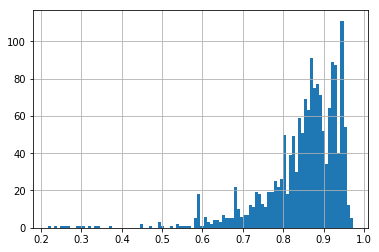

In [30]:
(final_df['prediction_dis_prob_no'] - final_df['prediction_dis_prob_yes']).hist(bins=100)

#### Minority Class (yes) Distribution

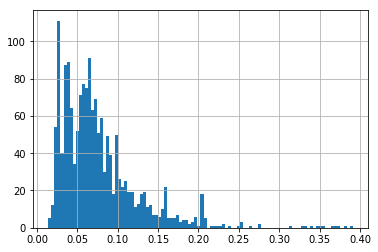

In [31]:
final_df['prediction_dis_prob_yes'].hist(bins=100)

In [32]:
threshold = calculate_threshold(140, final_df['prediction_dis_prob_yes'])
num = len(final_df[final_df['prediction_dis_prob_yes'] > threshold])
prop = (num/len(final_df))*100 
print(f'{str(round(prop,3))}% ({num}) of cases are above {str(threshold)}')

8.584% (140) of cases are above 0.144


### Home Remedy Myths

#### Probability Difference

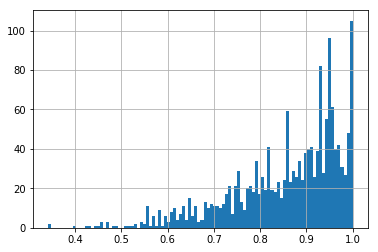

In [33]:
(final_df['prediction_rem_prob_no'] - final_df['prediction_rem_prob_yes']).hist(bins=100)

#### Minority Class (yes) Distribution

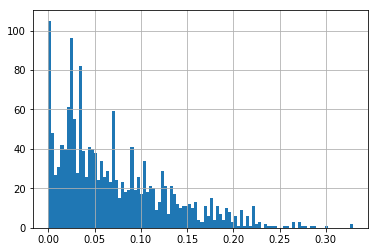

In [34]:
final_df['prediction_rem_prob_yes'].hist(bins=100)

In [35]:
threshold = calculate_threshold(140, final_df['prediction_rem_prob_yes'])
num = len(final_df[final_df['prediction_rem_prob_yes'] > threshold])
prop = (num/len(final_df))*100
print(f'{str(round(prop,3))}% ({num}) of cases are above {str(threshold)}')

8.706% (142) of cases are above 0.164


### Weather Myths

#### Probability Difference

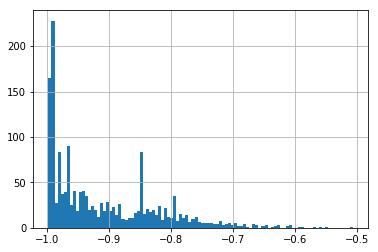

In [36]:
(final_df['prediction_wth_prob_no'] - final_df['prediction_wth_prob_yes']).hist(bins=100)

#### Minority Class (yes) Distribution
We're interested in "yes" cases here because it's easy to find "no" cases. <br>
Priority is to make sure our classifier can find "yes" cases (whether or not they are in majority in coded data).

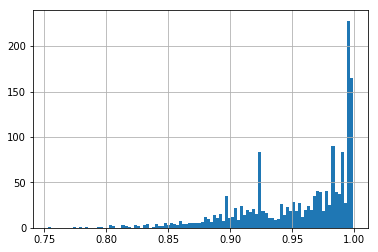

In [37]:
final_df['prediction_wth_prob_yes'].hist(bins=100)

In [38]:
threshold = calculate_threshold(225, final_df['prediction_wth_prob_yes'])
num = len(final_df[final_df['prediction_wth_prob_yes'] > threshold])
prop = (num/len(final_df))*100
print(f'{str(round(prop,3))}% ({num}) of cases are above {str(threshold)}')

100.0% (1631) of cases are above 0.5


## Select tweets for sample

Get sample of 180 new tweets (or 280 in case of weather), composed of 90% minority class and 10% majority class.<br>
To improve fidelity of model, make the tweets selected majority class fuzzy/unreliable, so model gets better at labeling these.<br>
First, filter into new DFs, one for minority class and one for (fuzzy) majority class.

In [39]:
# set thresholds for minority cases for each myth
# set these as low as possible to capture ~140 tweets likely to fall in minority class
capture_num = 162
minority_threshold_dis = calculate_threshold(capture_num,final_df['prediction_dis_prob_yes'])
minority_threshold_rem = calculate_threshold(capture_num,final_df['prediction_rem_prob_yes'])
minority_threshold_wth = calculate_threshold(252,final_df['prediction_wth_prob_yes']) # total of 250 sample

# filter using threshold
df_dis_minority = final_df[final_df['prediction_dis_prob_yes'] > minority_threshold_dis]
df_rem_minority = final_df[final_df['prediction_rem_prob_yes'] > minority_threshold_rem]
df_wth_minority = final_df[final_df['prediction_wth_prob_yes'] > minority_threshold_wth]

# check out results
print('Number of minority cases selected for each myth:')
print(f'{len(df_dis_minority)} for disinfectants')
print(f'{len(df_rem_minority)} for home remedies')
print(f'{len(df_wth_minority)} for weather')

Number of minority cases selected for each myth:
162 for disinfectants
164 for home remedies
1631 for weather


In [40]:
def check_pred_fuzzy(row, 
                     pred_labels = ['yes', 'no'], 
                     myth_labels = ['dis', 'rem', 'wth'],
                     upper_threshold=0.3, 
                     lower_threshold=0.10):
    
    '''
    Checks whether prediction is fuzzy/unreliable. Use this to determine if a tweet is worth hand-coding.
    Rationale: by only coding tweets with unreliable labels, we can improve the classifier's ability to detect 'unsure' cases.
    
    Function focuses on this difference: prob(predicted label) - prob(some other label).
    If difference is greater than lower_threshold (minimum for hand-coding of tweet to be possible), 
    but lesser than upper_threshold (maximum for hand-coding to be necessary), then it IS worth coding, so return True. 
    If difference is not between these, then we either it can't be reliably coded, or already have a reliable prediction,
    so we don't need to hand-code --> return False.

    To help select a threshold, ask: To what extent do we want the uncertainty to be, to help inform our sample selection?    
    For example, if a tweet is labeled as POS with 90% prob and NEG 10% --> this is very obvious sample, so don't bother coding.
    On the other hand, if the predictions are 51% NEG and 49 POS, then we need ppl to label this to update our model. 
    If our upper_threshold is 20% (0.20), then if a tweet has 61% NEG 39% POS probabilities, we don't choose it. 
    If some other tweet has prob 59% POS 41% NEG, we do select it for coding.
    
    Args:
        row: row corresponding to tweet, with predictions in format...
        pred_labels: labels for probabilities to use--used for naming columns
        myth_labels: labels for COVID-19 myths to detect--used for naming columns
        upper_threshold: max difference between predicted probs
        lower_threshold: min difference between predicted probs
    
    Returns:
        Array: True if tweet should be hand-coded, otherwise False. Array contains determinations for all myths
    '''
    
    worth_coding = []
    
    for myth in myth_labels:
        pred_label = row[f'prediction_{myth}'].strip() # get label of prediction for tweet--must be one of those in possible_labels!
        pred_score = float(row[f'prediction_{myth}_prob_{pred_label}']) # get probability of predicted label (probably high)
        
        for pred in pred_labels: # Look at each label
            pred = pred.strip() # clean label text
            
            if pred != pred_label: # if this label isn't the predicted one...
                difference = pred_score - float(row[f'prediction_{myth}_prob_{pred}']) # ...then look at their difference in probability
                if lower_threshold <= difference <= upper_threshold:
                 # if difference in probs is > lower_threshold but < upper_threshold, then pred is fuzzy and we should code
                    worth_coding.append(True) # worth coding
                
                else: worth_coding.append(False)
                    
    if len(worth_coding) == 1:
        return worth_coding[0]
    
    else: return worth_coding

In [41]:
df_dis_fuzzy = final_df[final_df.progress_apply(lambda x: check_pred_fuzzy(x, myth_labels = ['dis'], upper_threshold = .65), axis=1)]      
df_rem_fuzzy = final_df[final_df.progress_apply(lambda x: check_pred_fuzzy(x, myth_labels = ['rem'], upper_threshold = .65), axis=1)]
df_wth_fuzzy = final_df[final_df.progress_apply(lambda x: check_pred_fuzzy(x, myth_labels = ['wth'], upper_threshold = .65), axis=1)]
print(f'df_dis_fuzzy: {df_dis_fuzzy.shape}')
print(f'df_rem_fuzzy: {df_rem_fuzzy.shape}')
print(f'df_wth_fuzzy: {df_wth_fuzzy.shape}')

100%|██████████| 1631/1631 [00:00<00:00, 61658.70it/s]

df_dis_fuzzy: (75, 13)
df_rem_fuzzy: (122, 13)
df_wth_fuzzy: (20, 13)


## Compile sample

In [42]:
def sample_tweets(df, df_minority, df_fuzzy, sample_size=150, prop_maj=.1):
    '''
    Preliminary script to sample tweets using the previously determined minority and fuzzy df.
    Does not take into account distribution of dates.
    
    Args:
        df: original df with tweet id and full text
        df_minority: minority df with tweets above threshold
        sample_size: number of total tweets to sample
        prop_maj: proportion of total tweets to be majority label/fuzzy
        
    '''
    df_sample = pd.DataFrame()
    min_size = int(sample_size * (1-prop_maj))
    maj_size = sample_size - min_size
    
    for id in tqdm(df_minority['id'].sample(n=min_size)):
        df_sample = df_sample.append(df.loc[df['id'] == id][['id','created_at','full_text']],ignore_index=True)
    for id in tqdm(df_minority['id'].sample(n=maj_size)):
        df_sample = df_sample.append(df.loc[df['id'] == id][['id','created_at','full_text']],ignore_index=True)
#     df_sample = df_sample.rename(columns={'id': 'tweet_id'})
    df_sample = df_sample.sample(frac=1).reset_index(drop=True)
    return df_sample

dis_sample = sample_tweets(final_df,df_dis_minority,df_dis_fuzzy, sample_size = n_sample)
print(dis_sample.head(5))
rem_sample = sample_tweets(final_df,df_rem_minority,df_rem_fuzzy, sample_size = n_sample)
print(rem_sample.head(5))
wth_sample = sample_tweets(final_df,df_wth_minority, df_wth_fuzzy, sample_size = 280)
print(wth_sample.head(5))

 29%|██▉       | 47/162 [00:00<00:00, 464.74it/s]

                    id                created_at  \
0  1252363412497027078 2020-04-20 22:27:59+00:00   
1  1252363943449788417 2020-04-20 22:30:06+00:00   
2  1252202084541231105 2020-04-20 11:46:56+00:00   
3  1252209617020444678 2020-04-20 12:16:52+00:00   
4  1290804398935998464 2020-08-05 00:18:45+00:00   

                                           full_text  
0  Sick bastards. Spread this. #2019nCoV #COVID19...  
1  So sad. Looks like we got the flow out of hosp...  
2  ITS NORMAL TO FEEL SAD, STRESSED AND CONFUSED ...  
3  😷 TAIWAN: ❝Virus Outbreak: Social distancing l...  
4  How does @christufton, @themohwgovjm or even G...  


 18%|█▊        | 45/252 [00:00<00:00, 439.86it/s]

                    id                created_at  \
0  1262535766741139457 2020-05-19 00:09:18+00:00   
1  1279393572303900672 2020-07-04 12:36:12+00:00   
2  1290803454688890880 2020-08-05 00:15:00+00:00   
3  1252177328219672577 2020-04-20 10:08:34+00:00   
4  1252177073650589696 2020-04-20 10:07:33+00:00   

                                           full_text  
0  Plenty Pre-#COVID19 patients who'd been using ...  
1  @10DowningStreet Preliminary investigations co...  
2  “Doctors believe many people are fighting #Cov...  
3  New article: Strategies for Prevention of Coro...  
4  New article: Association of the COVID-19 pande...  


100%|██████████| 28/28 [00:00<00:00, 435.89it/s]

                    id                created_at  \
0  1279217386881720321 2020-07-04 00:56:06+00:00   
1  1294791116886167552 2020-08-16 00:20:32+00:00   
2  1262535512247730176 2020-05-19 00:08:17+00:00   
3  1279269617693863936 2020-07-04 04:23:39+00:00   
4  1262535494308712449 2020-05-19 00:08:13+00:00   

                                           full_text  
0  They played with lives of people for their pol...  
1  Dangerous ill-informed advisories from @CDC. I...  
2  ⭐️⭐️🇺🇸⭐️⭐️\nDear Plexiglas maker of ... well.....  
3  @SEKCSF @Pote78399148 @pigson0127 Can we retur...  
4  "seroprevalence study in Los Angeles County fi...  


### Check date distribution and remove column

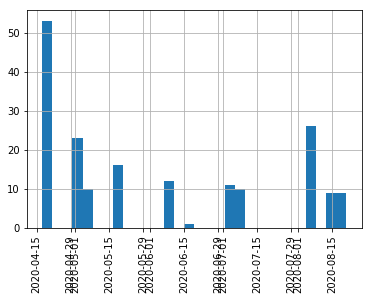

In [43]:
dis_sample['created_at'].hist(bins = 30, xrot = 90)
dis_sample.drop(columns = 'created_at', inplace = True)

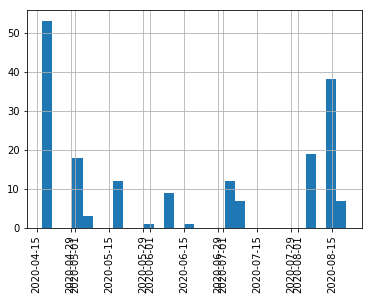

In [44]:
rem_sample['created_at'].hist(bins = 30, xrot = 90)
rem_sample.drop(columns = 'created_at', inplace = True)

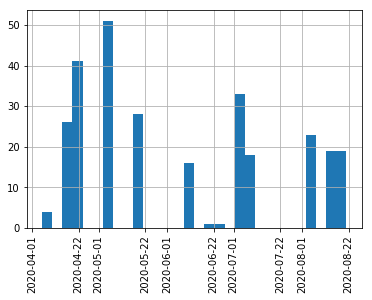

In [45]:
wth_sample['created_at'].hist(bins = 30, xrot = 90)
wth_sample.drop(columns = 'created_at', inplace = True)

## Clean text for MTurk (skip for now)

In [46]:
def process_mTurk_tweets(tweet):
    '''
    Process tweets for mTurk using MDI conventions
    
    Using remove_emojis, fix_hashtag, censor_text
    
    '''
    
    """
    Fix hashtags with following space character
    """
    tweet = tweet.replace("# ", "#")

    """
    Remove Emojis (they are not supported by MTurk)
    """
    tweet = emoji.get_emoji_regexp().sub(u'', tweet)


    """
    Censor text by removing URLs and @mentions
    """

    # Simple regular expression to match URLs starting with `https` or `http`
    # More complext regex an be found here: https://mathiasbynens.be/demo/url-regex
    url_regex = r"https?://\S*"

    # Regex to match mentions
    mention_regex = r"@\S*"

    # Count the number of replacements during regex replace to append a number
    # This is black magic, and was found here: https://stackoverflow.com/a/16761684
    class SubCount(object):
        def __init__(self, repl, start=1):
            self.count = start - 1
            self.repl = repl

        def __call__(self, match):
            self.count += 1
            return self.repl.format(self.count)

    # Replace URLs with URL<n> and handle with @USER<n>
    tweet = re.sub(url_regex, SubCount('<em>URL{0:02d} Removed</em>'), tweet)
    tweet = re.sub(mention_regex, SubCount('@USER{0:02d}'), tweet)
    
    return tweet

In [47]:
# # Process text for mTurk
# dis_sample['full_text'] = dis_sample['full_text'].progress_apply(lambda x: process_mTurk_tweets(x))
# rem_sample['full_text'] = rem_sample['full_text'].progress_apply(lambda x: process_mTurk_tweets(x))
# wth_sample['full_text'] = wth_sample['full_text'].progress_apply(lambda x: process_mTurk_tweets(x))

# print(dis_sample.head(5))
# print(rem_sample.head(5))
# print(wth_sample.head(5))

## Save to file

In [48]:
dis_sample.to_csv(dis_sam_fp,\
    escapechar='\"', \
    quotechar='\"',\
    quoting=csv.QUOTE_ALL,\
    index=False)
# rem_sample.to_csv(rem_sam_fp,\
#     escapechar='\"', \
#     quotechar='\"',\
#     quoting=csv.QUOTE_ALL,\
#     index=False)
# wth_sam_fp = f'../data/sample_280_tweets_weather_{str(thisday)}.csv'
# wth_sample.to_csv(wth_sam_fp,\
#     escapechar='\"', \
#     quotechar='\"',\
#     quoting=csv.QUOTE_ALL,\
#     index=False)